# Make Plots
A notebook to make the figures for our paper without needing to re-run experiments

In [1]:
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib import patches
from matplotlib import pyplot as plt
from scipy import stats
import pickle as pkl
import pandas as pd
import numpy as np
import os

## Load the Data
We need the results of fitting on the random channel

In [2]:
data = pd.read_pickle(os.path.join('data', 'random_data.pkl.gz')).query('not initial')
print('Data set size:', len(data))

Data set size: 9379


In [3]:
with open('model-comparision-results.pkl', 'rb') as fp:
    test_results = pkl.load(fp)

## Plot the Spearman vs MAE Model
We use this figure to show model accuracy and illustrate how we used physics to interpret the model performance.

In [4]:
experiment_number = len(test_results['bayes_poly']['over_time']['training_size']) // 2

In [5]:
small_forces = np.logical_and(data['force'] > 0, data['force'] < 0.4)
train_size = test_results['lasso']['over_time']['training_size'][experiment_number]
print('Training set size: ', train_size)
results = dict([
    (name, {'force_mae': np.abs(data['force'] - my_data['over_time']['traj'][experiment_number]).mean(),
            'small_force_mae': np.abs(data['force'][small_forces] - \
                                my_data['over_time']['traj'][experiment_number][small_forces]).mean(),
            'force_spearman': stats.spearmanr(data['force'],
                                              my_data['over_time']['traj'][experiment_number])[0]})
    for name, my_data in test_results.items()
])
del results['dummy']
over_time_results = pd.DataFrame(results).T
over_time_results.sort_values('force_spearman', ascending=False, inplace=True)
over_time_results

Training set size:  4690


/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,force_mae,small_force_mae,force_spearman
lasso+bayes_poly,0.025193,0.014376,0.993427
lasso_poly,0.030833,0.014682,0.992950
bayes,0.021878,0.017652,0.989804
lasso,0.039481,0.017298,0.989301
lasso+bayes,0.040101,0.019366,0.987726
bayes_poly,0.040411,0.013328,0.985654
ols,0.031191,0.023094,0.980189
pca+bayes_poly,0.047424,0.020076,0.973367


Test/test cutoff at timestep: 5110


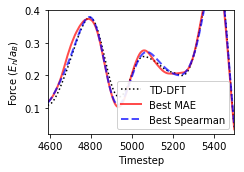

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

print(f"Test/test cutoff at timestep: {test_results['bayes_poly']['over_time']['step'][experiment_number]}")

# Plot the best MAE vs Best SCC
best_mae = 'bayes'
best_scc = 'lasso+bayes_poly'

tddft, = ax.plot(data['timestep'], data['force'], 'k:', lw=1.5, label='TD-DFT')
#tddft.set_label(None)
ax.set_ylim([0.02,0.4]) # Make sure the scales stay appropriate
ax.set_xlim(4590, 5500)

traj = test_results[best_mae]['over_time']['traj'][experiment_number]
ax.plot(data['timestep'], traj, 'r-', alpha=0.7, lw=2, label='Best MAE')

traj = test_results[best_scc]['over_time']['traj'][experiment_number]
ax.plot(data['timestep'], traj, 'b--', alpha=0.7, lw=2, label='Best Spearman')

ax.set_xlabel('Timestep')
ax.set_ylabel('Force ($E_h/a_B$)')
ax.legend(ncol=1, loc='lower right', framealpha=0.9)

#axs[1].text(0.0, 0.99, '(b)', va='top', transform=axs[1].transAxes)

fig.tight_layout()
fig.savefig(os.path.join('figures', 'mae-vs-spearman.png'), dpi=320)
fig.savefig(os.path.join('figures', 'mae-vs-spearman.pdf'))

Get the percent error in the stopping power

In [7]:
ape = (data['force'].mean() - test_results['bayes_poly']['over_time']['traj'][experiment_number].mean()) / data['force'].mean()
print(f'APE: {ape * 100:.2f}%')

APE: -0.20%


## Show the increase in fitting performance over time
The idea is to illustate how we need at least one near pass for the model to fit the random trajectory well.

/home/lward/miniconda3/envs/ml_tddft/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


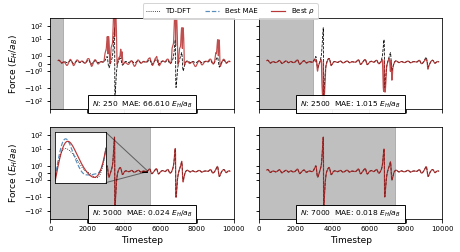

In [8]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6.5, 3.5))

best_results = test_results[best_scc]

axs[0, 0].set_xlim(0, 10000)
axs[0, 0].set_ylim(-400, 400)

for f,ax in zip([250, 2500, 5000, 7000],axs.flatten()):
    # Determine the index of the desired test
    f = test_results[best_scc]['over_time']['training_size'].index(f)
    
    ax.plot(data['timestep'], data['force'], 'k--', lw=.8)
    
    traj = test_results[best_scc]['over_time']['traj'][f]
    ax.plot(data['timestep'], traj, '-', color='firebrick', alpha=0.8, lw=1.2)
    traj_error = np.abs(traj - data['force']).mean()
    
    ax.text(0.5, 0, 
            '$N$: %d  MAE: %.3f $E_H/a_B$'%(best_results['over_time']['training_size'][f], traj_error),
            transform=ax.transAxes,
            ha='center', va='bottom',
            fontsize=7.5,
            bbox=dict(edgecolor='k', facecolor='w', alpha=0.95))
    
    ax.fill_between([-1, best_results['over_time']['step'][f]], -1000, 1000, color='gray', alpha=0.5,
                   edgecolor='none')
    
    ax.set_yscale('symlog')
    
    
# Plot a zoom-in for the bottom left. With both the SCC and otherwise
ax = axs[1, 0]
inset_ax = inset_axes(ax, 0.7, 0.7, loc='upper left')
best_mae = 'bayes'
best_scc = 'lasso+bayes_poly'

#   Determine the place where we are plotting 
tddft, = inset_ax.plot(data['timestep'], data['force'], 'k:', lw=0.8, label='TD-DFT')
inset_ax.set_ylim([0.19,0.29]) # Make sure the scales stay appropriate
inset_ax.set_xlim(5000, 5300)
inset_ax.set_xticks([])
inset_ax.set_yticks([])

traj = test_results[best_mae]['over_time']['traj'][experiment_number]
mae, = inset_ax.plot(data['timestep'], traj, '--', alpha=0.9, lw=1.2, label='Best MAE', color='steelblue')

traj = test_results[best_scc]['over_time']['traj'][experiment_number]
rho, = inset_ax.plot(data['timestep'], traj, 'b-', alpha=0.9, lw=1.2, label='Best $\\rho$',
             color='firebrick')

#   Make a box that shows the region
xy = (
    inset_ax.get_xlim()[0],
    inset_ax.get_ylim()[0]
)
height = inset_ax.get_ylim()[1] - inset_ax.get_ylim()[0]
width = inset_ax.get_xlim()[1] - inset_ax.get_xlim()[0]
box = patches.Rectangle(xy=xy, width=width, height=height,
                 edgecolor='k', fill=False)
axs[1, 0].add_patch(box)


#    Link our display box to the region
mark_inset(ax, inset_ax, 1, 4, alpha=0.5)



fig.legend(*inset_ax.get_legend_handles_labels(),
          ncol=3, fontsize=7, loc='upper center')

# Format the main axes
axs[1,0].set_xlabel('Timestep', fontsize=9)
axs[1,1].set_xlabel('Timestep', fontsize=9)
axs[0,0].set_ylabel('Force ($E_H/a_B$)', fontsize=9)
axs[1,0].set_ylabel('Force ($E_H/a_B$)', fontsize=9)

for ax in axs.flatten():
    ax.tick_params(axis='both', which='major', labelsize=7)

fig.tight_layout()

fig.savefig(os.path.join('figures', 'random-trajectory-fit.png'), dpi=320)
fig.savefig(os.path.join('figures', 'random-trajectory-fit.pdf'))